In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import Image

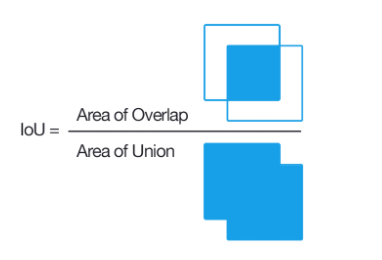

In [2]:
a =Image("D:\practice\博客\目标检测\img\lip_image005.png")
a

In [3]:
# from PIL import Image
# b = Image.open(r"D:\practice\博客\目标检测\img\lip_image005.png")
# b

In [4]:
query_box = [0,0,10,10]
boxes = [(5,5,15,15),(0,0,9,9),(1,1,8,8)]
query_box = np.array(query_box,dtype=np.float)
boxes = np.array(boxes,dtype=np.float)
print("query box : {}".format(query_box))
print("box : {}".format(boxes))
query_box[2]

query box : [ 0.  0. 10. 10.]
box : [[ 5.  5. 15. 15.]
 [ 0.  0.  9.  9.]
 [ 1.  1.  8.  8.]]


10.0

In [5]:
boxes[1,2]

9.0

In [6]:
boxes[1][2]

9.0

In [7]:
# compute all the IOUs between the N annostation boxes and the query_boxes
def compute_iou(boxes, query_boxes):
    """
    Args:
        boxes:       (N,4) ndarray of float
        query_boxes: (4)   ndarray of float  xmin,ymin,xmax,ymax
     Returns
        overlaps:    (N)   ndarray of overlap between boxes and query_boxes
    """
    N = boxes.shape[0]
    ious = np.zeros((N),dtype=np.float64)
    query_box_area=(
        (query_boxes[2]-query_boxes[0])*(query_boxes[3]-query_boxes[1])
    )
    for i in range(N):
        iw=(
#             min(boxes[i][2],query_boxes[2])-max(boxes[i][0],query_boxes[0])
             min(boxes[i,2],query_boxes[2])-max(boxes[i,0],query_boxes[0])
        )
        if iw>0:  
            ih=(
#                 min(boxes[i][3],query_boxes[3])-max(boxes[i][1],query_boxes[1])
                 min(boxes[i,3],query_boxes[3])-max(boxes[i,1],query_boxes[1])
            )
            if ih>0:
                oa=iw*ih
                box_area = np.float64(((boxes[i,2]-boxes[i,0])*(boxes[i,3]-boxes[i,1])))
                ua = query_box_area+box_area-oa
                ious[i]=oa/ua
    return ious

In [8]:
ious = compute_iou(boxes,query_box)
ious

array([0.14285714, 0.81      , 0.49      ])

In [9]:
# check if true positive or false positive
def check_if_true_or_false_positivate(annotations,detections,iou_threshold):
    """
    All detected bounding boxes will be assigned to the GT box that has the largest IOU. 
    Then check whether they are TP or FP by iou_threshold.
    Here, if multiple detected bounding boxes are mapped to the same GT box, then only the highest scored bounding box needs to be assigned to that GT. 
    So note that the detections passed to this function need to be pre-sorted.
    
    Args:
        annotations:      (N,4) ndarray of float
        detections:       (M,5) ndarray of float  xmin,ymin,xmax,ymax,score
        iou_threshuold    default:0.5  float
        
    Returns
        scores：          (M)   list of detection boxs's score
        false_positivate  (M)   list if detection box is FP,value=1.[1,0,0]
        true_positivate:  (M)   list if detection box id TP,value=1.[0,1,1]
    """
    annotations = np.array(annotations,dtype=np.float64)
    scores,false_positivate,true_positivate = [],[],[]
    detected_annotations = [] # a GT box should be mapped only one predicted box at most
    for query_box in detections:
        scores.append(query_box[4])
        if len(annotations)==0:
            false_positivate.append(1)
            true_positivate.append(0)
            continue
        ious = compute_iou(boxes=annotations,query_boxes=query_box[:4])
        assigned_annotation = np.argmax(ious)   # assigned anno index 
        max_iou = ious[assigned_annotation]
        if max_iou>=iou_threshold and assigned_annotation not in detected_annotations:
            true_positivate.append(1)
            false_positivate.append(0)
            detected_annotations.append(assigned_annotation)
        else:
            false_positivate.append(1)
            true_positivate.append(0)
    return scores,false_positivate,true_positivate

In [10]:
a = np.array([1,2,3,4,5],dtype=np.float64)
b = np.argmax(a)
c = np.max(a)
print("a=",a)
print("b=",b)
print("c=",c)

a= [1. 2. 3. 4. 5.]
b= 4
c= 5.0


In [11]:
anno = np.array([(1,1,6,6),(2,2,4,5),(4,9,5,19)],dtype=np.float64)
detect = np.array([[1,1,5,6,0.5],[2,2,4,5,0.8]],dtype=np.float64)
for i in anno:
    print(i[:-1])
print("anno:",anno)
print("len of anno:",len(anno))
print("detec:",detect)
print("size of detec:",detect.size)

[1. 1. 6.]
[2. 2. 4.]
[4. 9. 5.]
anno: [[ 1.  1.  6.  6.]
 [ 2.  2.  4.  5.]
 [ 4.  9.  5. 19.]]
len of anno: 3
detec: [[1.  1.  5.  6.  0.5]
 [2.  2.  4.  5.  0.8]]
size of detec: 10


In [12]:
scores,false_positivate,true_positivate=check_if_true_or_false_positivate(anno,detect,0.1)
print(scores)
print(false_positivate)
print(true_positivate)

[0.5, 0.8]
[0, 0]
[1, 1]


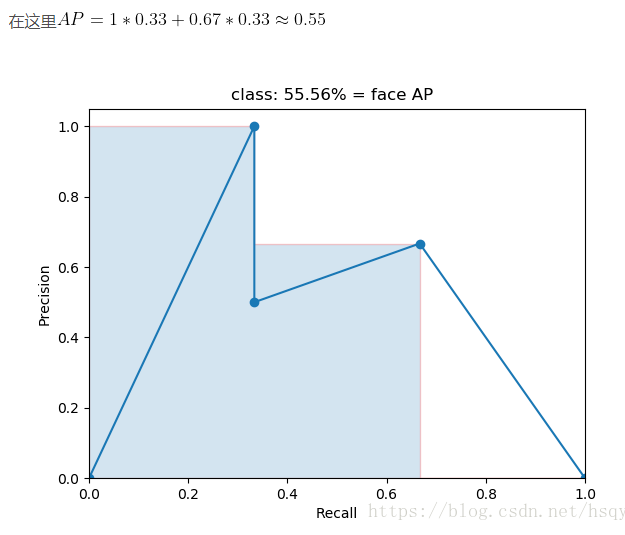

In [13]:
ap = Image(r"D:\practice\博客\目标检测\img\RP.png")
ap

In [14]:
# Average Precision Calculation
def compute_ap(recall,precision):
    """ 
    Compute the average precision, given the recall and precision curves.
    # Arguments
        recall:    The recall curve (list).
        precision: The precision curve (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """
    mrec = np.concatenate(([0.],recall,[1.]))
    mpre = np.concatenate(([0.],precision,[0.]))   # 参考上图的RP曲线，看两端
    
    # compute the precision envelope
    for i in range(mpre.size-1,0,-1):
        mpre[i-1]=np.maximum(mpre[i-1],mpre[i])
    
    i=np.where(mrec[1:]!=mrec[:-1])[0]      # where X axis (recall) changes value

    ap = np.sum((mrec[i+1]-mrec[i])*mpre[i+1])
    return ap

In [15]:
p = np.concatenate(([0.],[1.0,0.5,2/3],[0.]))
p

array([0.        , 1.        , 0.5       , 0.66666667, 0.        ])

In [16]:
r  = np.concatenate(([0.],[1/3,1/3,2/3],[1.]))
r

array([0.        , 0.33333333, 0.33333333, 0.66666667, 1.        ])

In [17]:
for i in range(p.size-1,0,-1):
    print("i:{}".format(i))
    p[i-1]=np.maximum(p[i-1],p[i])
    print("p:{}" .format(p[i-1]))
i = np.where(r[1:]!=r[:-1])[0]
print("p:{}".format(p))
print("i:{}".format(i))

i:4
p:0.6666666666666666
i:3
p:0.6666666666666666
i:2
p:1.0
i:1
p:1.0
p:[1.         1.         0.66666667 0.66666667 0.        ]
i:[0 2 3]


In [18]:
pre =[1.0,0.5,0.667]
rec = [0.33,0.33,0.667]
ap = compute_ap(rec,pre)
ap

0.554779

In [19]:
# get ground truth box with image id and label
def get_real_annotations(table):
    res = dict()
    ids = table['ImageID'].value.astype(np.str)
    labels = table['LabelName'].values.astype(np.str)
    xmin = table['XMin'].values.astype(np.float32)
    xmax = table['XMax'].values.astype(np.float32)
    ymin = table['YMin'].values.astype(np.float32)
    ymax = table['YMax'].values.astype(np.float32)
    
    for i in range(len(ids)):
        id = ids[i]
        label = labels[i]
        if id not in res:
            res[id] = dict()
        if label not in res[id]:
            res[id][label] = []
        box = [xmin[i], ymin[i], xmax[i], ymax[i]]
        res[id][label].append(box)
    
    return res

def get_detections(table):
    res = dict()
    ids = table['ImageID'].values.astype(np.str)
    labels = table['LabelName'].values.astype(np.str)
    scores = table['Conf'].values.astype(np.float32)
    xmin = table['XMin'].values.astype(np.float32)
    xmax = table['XMax'].values.astype(np.float32)
    ymin = table['YMin'].values.astype(np.float32)
    ymax = table['YMax'].values.astype(np.float32)

    for i in range(len(ids)):
        ida = ids[i]
        label = labels[i]
        if id not in res:
            res[id] = dict()
        if label not in res[id]:
            res[id][label] = []
        box = [xmin[i], ymin[i], xmax[i], ymax[i], scores[i]]
        res[ida][label].append(box)
    return res

In [25]:
# mean Average Precision Calculation
def mean_average_precision_for_boxes(ann,pred,iou_threshould=0.5, exclude_not_in_annotations=False, verbose=True):
    """
    :param ann: path to CSV-file with annotations or numpy array of shape (N, 6)
    :param pred: path to CSV-file with predictions (detections) or numpy array of shape (N, 7)
    :param iou_threshold: IoU between boxes which count as 'match'. Default: 0.5
    :param exclude_not_in_annotations: exclude image IDs which are not exist in annotations. Default: False
    :param verbose: print detailed run info. Default: True
    :return: tuple, where first value is mAP and second values is dict with AP for each class.
    """
    valid = pd.DataFrame(ann, columns=['ImageID', 'LabelName', 'XMin', 'XMax', 'YMin', 'YMax'])
    preds = pd.DataFrame(pred, columns=['ImageID', 'LabelName', 'Conf', 'XMin', 'XMax', 'YMin', 'YMax'])
    ann_unique = valid['ImageID'].unique()
    preds_unique = preds['ImageID'].unique()
    
    if verbose:
        print('Number of files in annotations: {}'.format(len(ann_unique)))
        print('Number of files in predictions: {}'.format(len(preds_unique)))
    
    # Exclude files not in annotations!
    if exclude_not_in_annotations:
        preds = preds[preds['ImageID'].isin(ann_unique)]
        preds_unique = preds['ImageID'].unique()
        if verbose:
            print('Number of files in detection after reduction: {}'.format(len(preds_unique)))

    unique_classes = valid['LabelName'].unique().astype(np.str)
    if verbose:
        print('Unique classes: {}'.format(len(unique_classes)))
        
    all_detections = get_detections(preds)
    all_annotations = get_real_annotations(valid)
    if verbose:
        print('Detections length: {}'.format(len(all_detections)))
        print('Annotations length: {}'.format(len(all_annotations)))
    
    average_precisions = {}
    for zz, label in enumerate(sorted(unique_classes)):
        # Negative class
        if str(label) == 'nan':
            continue

        false_positives = []
        true_positives = []
        scores = []
        num_annotations = 0.0

        for i in range(len(ann_unique)):
            detections = []
            annotations = []
            id = ann_unique[i]
            if id in all_detections:
                if label in all_detections[id]:
                    detections = all_detections[id][label]
            if id in all_annotations:
                if label in all_annotations[id]:
                    annotations = all_annotations[id][label]

            if len(detections) == 0 and len(annotations) == 0:
                continue

            num_annotations += len(annotations)
            scr, fp, tp = cehck_if_true_or_false_positive(annotations, detections, iou_threshold)

            scores += scr
            false_positives += fp
            true_positives += tp

        if num_annotations == 0:
            average_precisions[label] = 0, 0
            continue

        false_positives = np.array(false_positives)
        true_positives = np.array(true_positives)
        scores = np.array(scores)

        # sort by score
        indices = np.argsort(-scores)
        false_positives = false_positives[indices]
        true_positives = true_positives[indices]

        # compute false positives and true positives
        false_positives = np.cumsum(false_positives)
        true_positives = np.cumsum(true_positives)

        # compute recall and precision
        recall = true_positives / num_annotations
        precision = true_positives / np.maximum(true_positives + false_positives, np.finfo(np.float64).eps)

        # compute average precision
        average_precision = compute_ap(recall, precision)
        average_precisions[label] = average_precision, num_annotations, precision, recall
        if verbose:
            s1 = "{:30s} | {:.6f} | {:7d}".format(label, average_precision, int(num_annotations))
            print(s1)
        present_classes = 0
        precision = 0
        for label, (average_precision, num_annotations, _, _) in average_precisions.items():
            if num_annotations > 0:
                present_classes += 1
                precision += average_precision
        mean_ap = precision / present_classes
        if verbose:
            print('mAP: {:.6f}'.format(mean_ap))
        return mean_ap, average_precisions

In [ ]:
"""
置信度的作用
1.在check_if_true_or_false_positive()之前，检测框需要靠置信度进行排序
2.在计算Average Precision之前，列表true_positives和列表false_positives需要靠置信度进行排序

更低的置信度阈值，map会更高
"""